# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.


In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.advanced_weight_recovery import *
from pybatina.utils import *

In [3]:
import numpy as np

guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 0.6243526935577393
secret_number = int_to_float(float_to_int(secret_number))

print('secret_number =', secret_number)

secret_number = 0.6243526935577393


In [4]:
number_of_best_candidates = 10
awr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=10)

### Correlation of mantissa

In [5]:
%%time

numbers = None
mantissa_correlations = {}
for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):
    guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=numbers)
    known_inputs = awr.build_input_values(component='mantissa', mantissa_byte_index=mantissa_byte_index)
    secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
    mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)
    mantissa_correlations[mantissa_byte_index] = mantissa_corr
    numbers = mantissa_corr.index[:awr.number_of_best_candidates]

CPU times: user 20.1 s, sys: 543 ms, total: 20.6 s
Wall time: 21.7 s


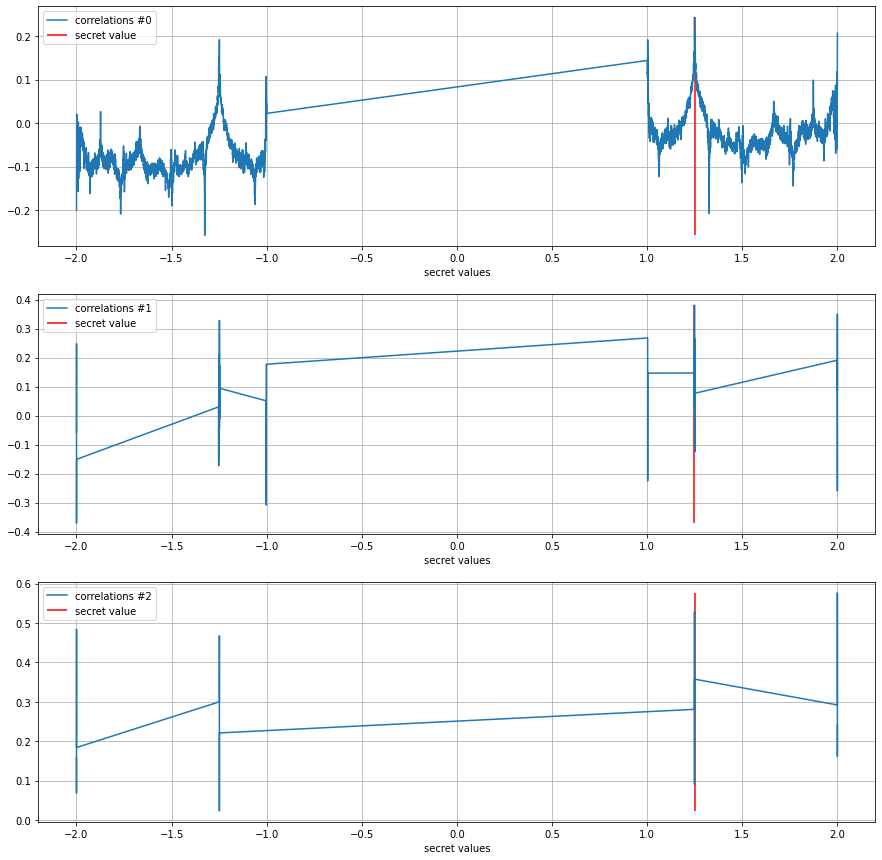

In [6]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=len(mantissa_correlations), ncols=1, figsize=(15, 5 * len(mantissa_correlations)))
for idx in range(len(mantissa_correlations)):
    corr = mantissa_correlations[idx].sort_index()
    corr.plot(ax=ax[idx], label='correlations #%d' % idx)
    x = int_to_float((float_to_int(secret_number) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
    ax[idx].vlines(x, corr.min(), corr.max(), color='red', label='secret value')
    ax[idx].legend()
    ax[idx].grid(True)
    ax[idx].set_xlabel('secret values')

In [7]:
mantissa_corr.iloc[:number_of_best_candidates]

1.999676    0.576594
1.999676    0.572247
1.999838    0.543751
1.248705    0.528762
1.999676    0.522413
1.248728    0.510296
1.248706    0.503706
1.248729    0.500890
1.248706    0.500088
1.999838    0.486758
dtype: float64

### Correlation exponent

In [8]:
%%time
known_inputs = awr.build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
guess_numbers = awr.build_guess_values(component='exponent', numbers=mantissa_corr.index[:awr.number_of_best_candidates])
guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]
mantisa_exp_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<timed exec>:4: RuntimeWarning: invalid value encountered in greater_equal
<timed exec>:4: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 831 ms, sys: 7.74 ms, total: 838 ms
Wall time: 967 ms


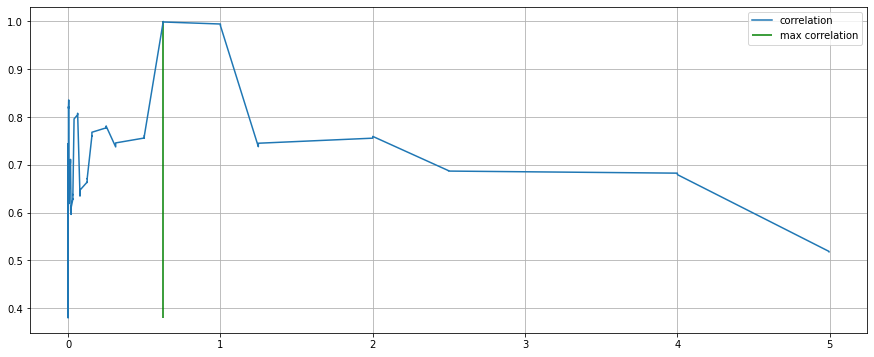

In [9]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
# ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [10]:
print('secret_number:', secret_number)
mantisa_exp_corr.iloc[:number_of_best_candidates]

secret_number: 0.6243526935577393


0.624353    1.000000
0.624353    1.000000
0.624364    0.999422
0.624364    0.998898
0.624353    0.998898
0.999838    0.994680
0.999838    0.994680
0.999919    0.991098
0.999919    0.991049
0.999838    0.991049
dtype: float64